In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

from torch.nn.parameter import Parameter
import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:0


In [2]:
data = scipy.io.loadmat('burgers_shock_10sin.mat')  	# Load data from file

pi = torch.from_numpy(np.array(np.pi)).double().to(device)

label = "QCRE_2D_5_tanh"
x = data['x']                                   # 256 points between -1 and 1 [256x1]
t = data['t']                                   # 100 time points between 0 and 1 [100x1] 
usol = data['usol']   

#usol = usol/1000# solution of 256x100 grid points

X, T = np.meshgrid(x,t)   

In [3]:
def trainingdata(N_u,N_f,seed):

    '''Boundary Conditions'''
    #Initial Condition -1 =< x =<1 and t = 0  
    leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
    leftedge_u = usol[:,0][:,None]

    #Boundary Condition x = -1 and 0 =< t =<1
    bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
    bottomedge_u = usol[-1,:][:,None]

    #Boundary Condition x = 1 and 0 =< t =<1
    topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
    topedge_u = usol[0,:][:,None]

    all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
    all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]
    
    np.random.seed(seed)
    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 

    X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx,:]      #choose corresponding u

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f_train = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 

    return X_f_train, X_u_train, u_train

In [4]:
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_test[0]  # [-1. 0.]
ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_true = usol.flatten('F')[:,None]

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        '''
        Alternatively:
        
        *all layers are callable 
    
        Simple linear Layers
        self.fc1 = nn.Linear(2,50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,1)
        
        '''
    
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        self.train_loss = []
        self.test_loss = []

    'foward pass'
    def forward(self,x):
         if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
         u_b = torch.from_numpy(ub).float().to(device)
         l_b = torch.from_numpy(lb).float().to(device)
                      
         #preprocessing input 
         x = (x - l_b)/(u_b - l_b) #feature scaling
        
         #convert to float
         a = x.float()
                        
         '''     
         Alternatively:
        
         a = self.activation(self.fc1(a))
         a = self.activation(self.fc2(a))
         a = self.activation(self.fc3(a))
         a = self.fc4(a)
         
         '''
        
         for i in range(len(layers)-2):
                z = self.linears[i](a)
                a = self.activation(z)
         
         a = self.linears[-1](a)
        
         return a
                        
    def loss_BC(self,x,y):
                
        loss_u = self.loss_function(self.forward(x), y)
                
        return loss_u
    
    def loss_PDE(self, x_to_train_f):
        
        nu = 0.01/pi
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        u = self.forward(g)
                
        u_x_t = autograd.grad(u,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(x_to_train_f.shape).to(device), create_graph=True)[0]
                                                            
        u_x = u_x_t[:,[0]]
        
        u_t = u_x_t[:,[1]]
        
        u_xx = u_xx_tt[:,[0]]
                                        
        f = u_t + (self.forward(g))*(u_x) - (nu)*u_xx 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,x,y,x_to_train_f):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f)
        
        loss_val = loss_u + loss_f
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        optimizer.zero_grad()
        loss = self.loss(X_u_train, u_train, X_f_train)
        
        self.train_loss.append(loss.cpu().detach().numpy())
        
        u_pred = self.test(X_u_test_tensor)
        self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1))))
    
        
        print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
        
        loss.backward()
        self.iter += 1
     
        return loss        
    'test neural network'
    
    def test(self,xt_test_tensor):
        u_pred = self.forward(X_u_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

In [6]:
max_reps = 1

train_loss_full = []
test_loss_full = []

elapsed_time= np.zeros((max_reps,1))


for reps in range(max_reps):
    print(reps)
    N_u = 200 #Total number of data points for 'u'
    N_f = 10000 #Total number of collocation points 
    X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u,N_f,reps*43)

    'Convert to tensor and send to GPU'
    X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
    X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)
    u = torch.from_numpy(u_true).float().to(device)
    f_hat = torch.zeros(X_f_train.shape[0],1).to(device)

    layers = np.array([2,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

    PINN = Sequentialmodel(layers)
       
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())


    'L-BFGS Optimizer'
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                                  max_iter = 3000, 
                                  max_eval = None, 
                                  tolerance_grad = -1, 
                                  tolerance_change = -1, 
                                  history_size = 100, 
                                  line_search_fn = 'strong_wolfe')

    start_time = time.time()

    optimizer.step(PINN.closure)
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(PINN.train_loss)
    test_loss_full.append(PINN.test_loss)
    elapsed_time[reps] = time.time() - start_time

    

mdic = {"train_loss": train_loss_full,"test_loss": test_loss_full,"Time": elapsed_time, "label": label}
savemat(label+'.mat', mdic) 

0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0 Train Loss 28.172722 Test Loss 24.561405385541537
1 Train Loss 27.637793 Test Loss 24.566114618714664
2 Train Loss 26.33612 Test Loss 24.53785412869091
3 Train Loss 26.249994 Test Loss 24.465298855536826
4 Train Loss 25.623575 Test Loss 23.909603560442065
5 Train Loss 25.783354 Test Loss 22.310608

146 Train Loss 16.518158 Test Loss 12.868397592460981
147 Train Loss 16.642715 Test Loss 13.018704854153288
148 Train Loss 16.505041 Test Loss 12.901658866968535
149 Train Loss 16.50752 Test Loss 12.9723648023695
150 Train Loss 16.497408 Test Loss 12.934103309621372
151 Train Loss 16.4934 Test Loss 12.937639880350488
152 Train Loss 16.489002 Test Loss 12.95210663939675
153 Train Loss 16.48506 Test Loss 12.956868174415222
154 Train Loss 16.480028 Test Loss 12.966095189811766
155 Train Loss 16.476593 Test Loss 12.970556353073235
156 Train Loss 16.473722 Test Loss 12.972173123625451
157 Train Loss 16.47143 Test Loss 12.963902452100307
158 Train Loss 16.467274 Test Loss 12.95277534165897
159 Train Loss 16.459421 Test Loss 12.942837726009325
160 Train Loss 16.43145 Test Loss 12.926367735035125
161 Train Loss 16.379112 Test Loss 12.904307923187638
162 Train Loss 16.377018 Test Loss 12.883887855826002
163 Train Loss 16.347265 Test Loss 12.892260324495485
164 Train Loss 16.328411 Test Loss 12.

301 Train Loss 14.797638 Test Loss 12.216026305781977
302 Train Loss 14.781034 Test Loss 12.213217097508526
303 Train Loss 14.821375 Test Loss 12.209692311101458
304 Train Loss 14.751292 Test Loss 12.21227806911856
305 Train Loss 14.728546 Test Loss 12.245534839255976
306 Train Loss 14.720148 Test Loss 12.245248684809868
307 Train Loss 14.713409 Test Loss 12.251469616535106
308 Train Loss 14.708813 Test Loss 12.25512912953261
309 Train Loss 14.699581 Test Loss 12.254473801532402
310 Train Loss 14.682312 Test Loss 12.245856341778676
311 Train Loss 14.66529 Test Loss 12.23135815837908
312 Train Loss 14.828284 Test Loss 12.23933842757965
313 Train Loss 14.658122 Test Loss 12.229361943019267
314 Train Loss 14.634983 Test Loss 12.192064878529747
315 Train Loss 14.664459 Test Loss 12.173089637299011
316 Train Loss 14.622548 Test Loss 12.184088136419216
317 Train Loss 14.6199045 Test Loss 12.16299517912046
318 Train Loss 14.6065 Test Loss 12.171851167112033
319 Train Loss 14.597953 Test Loss 

455 Train Loss 13.936239 Test Loss 11.784701008353473
456 Train Loss 13.9325075 Test Loss 11.785986867112218
457 Train Loss 13.929922 Test Loss 11.788706640108183
458 Train Loss 13.927471 Test Loss 11.788091356495773
459 Train Loss 13.929529 Test Loss 11.78563666442167
460 Train Loss 13.924345 Test Loss 11.786650554001044
461 Train Loss 13.92113 Test Loss 11.786096063983507
462 Train Loss 13.919532 Test Loss 11.784909454024486
463 Train Loss 13.918615 Test Loss 11.785241911354603
464 Train Loss 13.915983 Test Loss 11.783811902236414
465 Train Loss 13.913494 Test Loss 11.785989712475107
466 Train Loss 13.913557 Test Loss 11.789421244780401
467 Train Loss 13.912474 Test Loss 11.78765221236226
468 Train Loss 13.910263 Test Loss 11.790280067367098
469 Train Loss 13.908322 Test Loss 11.78889330625588
470 Train Loss 13.906702 Test Loss 11.78664400848441
471 Train Loss 13.9064865 Test Loss 11.783576463359593
472 Train Loss 13.904557 Test Loss 11.78088432075517
473 Train Loss 13.903986 Test Lo

608 Train Loss 13.70055 Test Loss 11.680058929501449
609 Train Loss 13.699205 Test Loss 11.682149856349138
610 Train Loss 13.6981735 Test Loss 11.679941562326514
611 Train Loss 13.697513 Test Loss 11.675517396054188
612 Train Loss 13.696278 Test Loss 11.670959903350761
613 Train Loss 13.694331 Test Loss 11.670812412712598
614 Train Loss 13.692715 Test Loss 11.670953528866464
615 Train Loss 13.691534 Test Loss 11.677736608116424
616 Train Loss 13.689233 Test Loss 11.67548788186388
617 Train Loss 13.686552 Test Loss 11.671278043540461
618 Train Loss 13.688059 Test Loss 11.66715050407509
619 Train Loss 13.685221 Test Loss 11.669466243445996
620 Train Loss 13.683458 Test Loss 11.66921246932953
621 Train Loss 13.688312 Test Loss 11.670900915469131
622 Train Loss 13.681668 Test Loss 11.669827829015697
623 Train Loss 13.679465 Test Loss 11.66624419344196
624 Train Loss 13.677845 Test Loss 11.66195793160699
625 Train Loss 13.674048 Test Loss 11.657790925796375
626 Train Loss 13.671054 Test Los

764 Train Loss 13.503051 Test Loss 11.540804712486235
765 Train Loss 13.503965 Test Loss 11.526035928701521
766 Train Loss 13.50232 Test Loss 11.533335044692874
767 Train Loss 13.501725 Test Loss 11.52386385091944
768 Train Loss 13.500935 Test Loss 11.510719983520424
769 Train Loss 13.500582 Test Loss 11.493390561447988
770 Train Loss 13.499968 Test Loss 11.50006826649002
771 Train Loss 13.498845 Test Loss 11.495446031687495
772 Train Loss 13.498386 Test Loss 11.499865831392775
773 Train Loss 13.496963 Test Loss 11.485985584618478
774 Train Loss 13.496578 Test Loss 11.477408785602796
775 Train Loss 13.496172 Test Loss 11.477595183325631
776 Train Loss 13.49588 Test Loss 11.473005618597847
777 Train Loss 13.49572 Test Loss 11.47103677506285
778 Train Loss 13.495515 Test Loss 11.471392823187118
779 Train Loss 13.49517 Test Loss 11.468194399485103
780 Train Loss 13.494808 Test Loss 11.468532590302909
781 Train Loss 13.497254 Test Loss 11.476361766465898
782 Train Loss 13.494712 Test Loss 

920 Train Loss 13.126817 Test Loss 11.255179407219696
921 Train Loss 13.125327 Test Loss 11.25696384085798
922 Train Loss 13.124388 Test Loss 11.257444690006519
923 Train Loss 13.123561 Test Loss 11.258343254957147
924 Train Loss 13.12295 Test Loss 11.260339844585053
925 Train Loss 13.122419 Test Loss 11.262319667106528
926 Train Loss 13.122149 Test Loss 11.265888307118368
927 Train Loss 13.122005 Test Loss 11.266564977658204
928 Train Loss 13.121846 Test Loss 11.267776562603775
929 Train Loss 13.1215515 Test Loss 11.269815027915158
930 Train Loss 13.121337 Test Loss 11.269573527464052
931 Train Loss 13.1217165 Test Loss 11.270048876550872
932 Train Loss 13.121181 Test Loss 11.269737045573368
933 Train Loss 13.120777 Test Loss 11.26822290351552
934 Train Loss 13.120253 Test Loss 11.264303096249998
935 Train Loss 13.121862 Test Loss 11.26191449357388
936 Train Loss 13.119914 Test Loss 11.263398560581216
937 Train Loss 13.11919 Test Loss 11.262878369512977
938 Train Loss 13.118076 Test L

1074 Train Loss 12.970573 Test Loss 11.212270213405509
1075 Train Loss 12.967225 Test Loss 11.208188026072502
1076 Train Loss 12.9648905 Test Loss 11.204319361691855
1077 Train Loss 12.979324 Test Loss 11.19024152438615
1078 Train Loss 12.961753 Test Loss 11.198858086258365
1079 Train Loss 12.957692 Test Loss 11.193643056806682
1080 Train Loss 12.954727 Test Loss 11.195320895250925
1081 Train Loss 12.953815 Test Loss 11.195162957432666
1082 Train Loss 12.952441 Test Loss 11.195198050260771
1083 Train Loss 12.950355 Test Loss 11.195846704898292
1084 Train Loss 12.949801 Test Loss 11.204024069845202
1085 Train Loss 12.946484 Test Loss 11.197332316720281
1086 Train Loss 12.945116 Test Loss 11.189968784814322
1087 Train Loss 12.943607 Test Loss 11.188524187375513
1088 Train Loss 12.9424305 Test Loss 11.18828571247719
1089 Train Loss 12.941744 Test Loss 11.188742937171614
1090 Train Loss 12.940741 Test Loss 11.189741041046629
1091 Train Loss 12.939729 Test Loss 11.188979555686645
1092 Train

1226 Train Loss 12.67792 Test Loss 11.09958035753567
1227 Train Loss 12.674081 Test Loss 11.099170975258305
1228 Train Loss 12.688646 Test Loss 11.094479108364988
1229 Train Loss 12.66564 Test Loss 11.096872963969716
1230 Train Loss 12.656545 Test Loss 11.090557904372154
1231 Train Loss 12.639796 Test Loss 11.069641072889242
1232 Train Loss 13.023148 Test Loss 11.040697467490602
1233 Train Loss 12.63885 Test Loss 11.067599266808749
1234 Train Loss 12.632466 Test Loss 11.0624211411501
1235 Train Loss 13.185889 Test Loss 11.032601536751867
1236 Train Loss 12.629912 Test Loss 11.058409919556278
1237 Train Loss 12.622987 Test Loss 11.058890578825588
1238 Train Loss 12.617173 Test Loss 11.062926071667325
1239 Train Loss 12.6119175 Test Loss 11.063339038360946
1240 Train Loss 12.618884 Test Loss 11.05893059252175
1241 Train Loss 12.6085825 Test Loss 11.061307436423897
1242 Train Loss 12.604446 Test Loss 11.044695082688031
1243 Train Loss 12.602265 Test Loss 11.037780241399075
1244 Train Loss

1377 Train Loss 12.418139 Test Loss 10.834477288846374
1378 Train Loss 12.399993 Test Loss 10.848425018484033
1379 Train Loss 12.389771 Test Loss 10.833476816142143
1380 Train Loss 12.414187 Test Loss 10.756932958334874
1381 Train Loss 12.379659 Test Loss 10.797937911715508
1382 Train Loss 56.845585 Test Loss 10.560225252657958
1383 Train Loss 12.688868 Test Loss 10.740427198900706
1384 Train Loss 12.37692 Test Loss 10.785472355847691
1385 Train Loss 12.457464 Test Loss 10.718415842311416
1386 Train Loss 12.360902 Test Loss 10.75852094093211
1387 Train Loss 12.368811 Test Loss 10.735979908743866
1388 Train Loss 12.35223 Test Loss 10.74834065228602
1389 Train Loss 13.221541 Test Loss 10.681186498630092
1390 Train Loss 12.33829 Test Loss 10.727435398573341
1391 Train Loss 12.36867 Test Loss 10.714115623483693
1392 Train Loss 12.327641 Test Loss 10.721735221184929
1393 Train Loss 12.323581 Test Loss 10.712234439673441
1394 Train Loss 12.321207 Test Loss 10.710292077614884
1395 Train Loss 

1530 Train Loss 12.278187 Test Loss 10.690071151240073
1531 Train Loss 12.277858 Test Loss 10.693529650196144
1532 Train Loss 12.27763 Test Loss 10.696023334057584
1533 Train Loss 12.277225 Test Loss 10.694105882578736
1534 Train Loss 12.276733 Test Loss 10.692003074981528
1535 Train Loss 12.276436 Test Loss 10.690554747182764
1536 Train Loss 12.276045 Test Loss 10.690535720388025
1537 Train Loss 12.275582 Test Loss 10.690491841938746
1538 Train Loss 12.275118 Test Loss 10.690587688870934
1539 Train Loss 12.274889 Test Loss 10.689645504055857
1540 Train Loss 12.274269 Test Loss 10.688557911080947
1541 Train Loss 12.273703 Test Loss 10.686430963668663
1542 Train Loss 12.273238 Test Loss 10.68276099215001
1543 Train Loss 12.272893 Test Loss 10.684005949914955
1544 Train Loss 12.273214 Test Loss 10.68035397372649
1545 Train Loss 12.27237 Test Loss 10.682189875459766
1546 Train Loss 12.271712 Test Loss 10.67930333072905
1547 Train Loss 12.270944 Test Loss 10.676505091037809
1548 Train Loss

1681 Train Loss 12.218868 Test Loss 10.658135237554983
1682 Train Loss 12.217169 Test Loss 10.657840833788423
1683 Train Loss 12.215367 Test Loss 10.656015869699386
1684 Train Loss 12.214303 Test Loss 10.650560613763188
1685 Train Loss 12.222661 Test Loss 10.645694774182259
1686 Train Loss 12.212879 Test Loss 10.64878156999537
1687 Train Loss 12.21221 Test Loss 10.646160980488103
1688 Train Loss 12.210669 Test Loss 10.6362959835726
1689 Train Loss 12.210741 Test Loss 10.620640057557724
1690 Train Loss 12.209783 Test Loss 10.627466505261612
1691 Train Loss 12.208467 Test Loss 10.619009590724929
1692 Train Loss 12.207347 Test Loss 10.61571643400199
1693 Train Loss 162.02252 Test Loss 11.124683367373855
1694 Train Loss 12.207328 Test Loss 10.615753658597187
1695 Train Loss 12.376346 Test Loss 10.651984821643893
1696 Train Loss 12.207291 Test Loss 10.61676187779548
1697 Train Loss 12.20663 Test Loss 10.609242691279157
1698 Train Loss 12.212813 Test Loss 10.60392415090179
1699 Train Loss 12

1833 Train Loss 12.184232 Test Loss 10.584318848736519
1834 Train Loss 12.199106 Test Loss 10.583647170828074
1835 Train Loss 12.18413 Test Loss 10.584187938204538
1836 Train Loss 12.183723 Test Loss 10.584250963691495
1837 Train Loss 12.182851 Test Loss 10.58414085994569
1838 Train Loss 12.182723 Test Loss 10.581279577137474
1839 Train Loss 12.185348 Test Loss 10.577223805385357
1840 Train Loss 12.182446 Test Loss 10.580066491708342
1841 Train Loss 12.1819515 Test Loss 10.58075335308632
1842 Train Loss 12.181625 Test Loss 10.581560050366265
1843 Train Loss 12.180858 Test Loss 10.579816789040967
1844 Train Loss 12.180652 Test Loss 10.576079602405747
1845 Train Loss 12.180301 Test Loss 10.574618996791456
1846 Train Loss 12.1800585 Test Loss 10.575378686213414
1847 Train Loss 12.179837 Test Loss 10.575124783855815
1848 Train Loss 12.179672 Test Loss 10.575031025147517
1849 Train Loss 12.179558 Test Loss 10.573914190338979
1850 Train Loss 12.179434 Test Loss 10.574306164706101
1851 Train 

1983 Train Loss 12.160541 Test Loss 10.56480506934321
1984 Train Loss 12.160548 Test Loss 10.564829789169396
1985 Train Loss 12.160537 Test Loss 10.564832629318865
1986 Train Loss 2719.9526 Test Loss 10.115340012609533
1987 Train Loss 85.05307 Test Loss 10.194516022073536
1988 Train Loss 12.160541 Test Loss 10.56480506934321
1989 Train Loss 12.160548 Test Loss 10.564829789169396
1990 Train Loss 12.160537 Test Loss 10.564832629318865
1991 Train Loss 2719.9526 Test Loss 10.115340012609533
1992 Train Loss 85.05307 Test Loss 10.194516022073536
1993 Train Loss 12.160541 Test Loss 10.56480506934321
1994 Train Loss 12.160548 Test Loss 10.564829789169396
1995 Train Loss 12.160537 Test Loss 10.564832629318865
1996 Train Loss 2719.9526 Test Loss 10.115340012609533
1997 Train Loss 85.05307 Test Loss 10.194516022073536
1998 Train Loss 12.160541 Test Loss 10.56480506934321
1999 Train Loss 12.160548 Test Loss 10.564829789169396
2000 Train Loss 12.160537 Test Loss 10.564832629318865
2001 Train Loss 2

2136 Train Loss 2719.9526 Test Loss 10.115340012609533
2137 Train Loss 85.05307 Test Loss 10.194516022073536
2138 Train Loss 12.160541 Test Loss 10.56480506934321
2139 Train Loss 12.160548 Test Loss 10.564829789169396
2140 Train Loss 12.160537 Test Loss 10.564832629318865
2141 Train Loss 2719.9526 Test Loss 10.115340012609533
2142 Train Loss 85.05307 Test Loss 10.194516022073536
2143 Train Loss 12.160541 Test Loss 10.56480506934321
2144 Train Loss 12.160548 Test Loss 10.564829789169396
2145 Train Loss 12.160537 Test Loss 10.564832629318865
2146 Train Loss 2719.9526 Test Loss 10.115340012609533
2147 Train Loss 85.05307 Test Loss 10.194516022073536
2148 Train Loss 12.160541 Test Loss 10.56480506934321
2149 Train Loss 12.160548 Test Loss 10.564829789169396
2150 Train Loss 12.160537 Test Loss 10.564832629318865
2151 Train Loss 2719.9526 Test Loss 10.115340012609533
2152 Train Loss 85.05307 Test Loss 10.194516022073536
2153 Train Loss 12.160541 Test Loss 10.56480506934321
2154 Train Loss 12

2291 Train Loss 2719.9526 Test Loss 10.115340012609533
2292 Train Loss 85.05307 Test Loss 10.194516022073536
2293 Train Loss 12.160541 Test Loss 10.56480506934321
2294 Train Loss 12.160548 Test Loss 10.564829789169396
2295 Train Loss 12.160537 Test Loss 10.564832629318865
2296 Train Loss 2719.9526 Test Loss 10.115340012609533
2297 Train Loss 85.05307 Test Loss 10.194516022073536
2298 Train Loss 12.160541 Test Loss 10.56480506934321
2299 Train Loss 12.160548 Test Loss 10.564829789169396
2300 Train Loss 12.160537 Test Loss 10.564832629318865
2301 Train Loss 2719.9526 Test Loss 10.115340012609533
2302 Train Loss 85.05307 Test Loss 10.194516022073536
2303 Train Loss 12.160541 Test Loss 10.56480506934321
2304 Train Loss 12.160548 Test Loss 10.564829789169396
2305 Train Loss 12.160537 Test Loss 10.564832629318865
2306 Train Loss 2719.9526 Test Loss 10.115340012609533
2307 Train Loss 85.05307 Test Loss 10.194516022073536
2308 Train Loss 12.160541 Test Loss 10.56480506934321
2309 Train Loss 12

2444 Train Loss 12.160548 Test Loss 10.564829789169396
2445 Train Loss 12.160537 Test Loss 10.564832629318865
2446 Train Loss 2719.9526 Test Loss 10.115340012609533
2447 Train Loss 85.05307 Test Loss 10.194516022073536
2448 Train Loss 12.160541 Test Loss 10.56480506934321
2449 Train Loss 12.160548 Test Loss 10.564829789169396
2450 Train Loss 12.160537 Test Loss 10.564832629318865
2451 Train Loss 2719.9526 Test Loss 10.115340012609533
2452 Train Loss 85.05307 Test Loss 10.194516022073536
2453 Train Loss 12.160541 Test Loss 10.56480506934321
2454 Train Loss 12.160548 Test Loss 10.564829789169396
2455 Train Loss 12.160537 Test Loss 10.564832629318865
2456 Train Loss 2719.9526 Test Loss 10.115340012609533
2457 Train Loss 85.05307 Test Loss 10.194516022073536
2458 Train Loss 12.160541 Test Loss 10.56480506934321
2459 Train Loss 12.160548 Test Loss 10.564829789169396
2460 Train Loss 12.160537 Test Loss 10.564832629318865
2461 Train Loss 2719.9526 Test Loss 10.115340012609533
2462 Train Loss 

2598 Train Loss 12.160541 Test Loss 10.56480506934321
2599 Train Loss 12.160548 Test Loss 10.564829789169396
2600 Train Loss 12.160537 Test Loss 10.564832629318865
2601 Train Loss 2719.9526 Test Loss 10.115340012609533
2602 Train Loss 85.05307 Test Loss 10.194516022073536
2603 Train Loss 12.160541 Test Loss 10.56480506934321
2604 Train Loss 12.160548 Test Loss 10.564829789169396
2605 Train Loss 12.160537 Test Loss 10.564832629318865
2606 Train Loss 2719.9526 Test Loss 10.115340012609533
2607 Train Loss 85.05307 Test Loss 10.194516022073536
2608 Train Loss 12.160541 Test Loss 10.56480506934321
2609 Train Loss 12.160548 Test Loss 10.564829789169396
2610 Train Loss 12.160537 Test Loss 10.564832629318865
2611 Train Loss 2719.9526 Test Loss 10.115340012609533
2612 Train Loss 85.05307 Test Loss 10.194516022073536
2613 Train Loss 12.160541 Test Loss 10.56480506934321
2614 Train Loss 12.160548 Test Loss 10.564829789169396
2615 Train Loss 12.160537 Test Loss 10.564832629318865
2616 Train Loss 2

2752 Train Loss 85.05307 Test Loss 10.194516022073536
2753 Train Loss 12.160541 Test Loss 10.56480506934321
2754 Train Loss 12.160548 Test Loss 10.564829789169396
2755 Train Loss 12.160537 Test Loss 10.564832629318865
2756 Train Loss 2719.9526 Test Loss 10.115340012609533
2757 Train Loss 85.05307 Test Loss 10.194516022073536
2758 Train Loss 12.160541 Test Loss 10.56480506934321
2759 Train Loss 12.160548 Test Loss 10.564829789169396
2760 Train Loss 12.160537 Test Loss 10.564832629318865
2761 Train Loss 2719.9526 Test Loss 10.115340012609533
2762 Train Loss 85.05307 Test Loss 10.194516022073536
2763 Train Loss 12.160541 Test Loss 10.56480506934321
2764 Train Loss 12.160548 Test Loss 10.564829789169396
2765 Train Loss 12.160537 Test Loss 10.564832629318865
2766 Train Loss 2719.9526 Test Loss 10.115340012609533
2767 Train Loss 85.05307 Test Loss 10.194516022073536
2768 Train Loss 12.160541 Test Loss 10.56480506934321
2769 Train Loss 12.160548 Test Loss 10.564829789169396
2770 Train Loss 12

2904 Train Loss 12.160548 Test Loss 10.564829789169396
2905 Train Loss 12.160537 Test Loss 10.564832629318865
2906 Train Loss 2719.9526 Test Loss 10.115340012609533
2907 Train Loss 85.05307 Test Loss 10.194516022073536
2908 Train Loss 12.160541 Test Loss 10.56480506934321
2909 Train Loss 12.160548 Test Loss 10.564829789169396
2910 Train Loss 12.160537 Test Loss 10.564832629318865
2911 Train Loss 2719.9526 Test Loss 10.115340012609533
2912 Train Loss 85.05307 Test Loss 10.194516022073536
2913 Train Loss 12.160541 Test Loss 10.56480506934321
2914 Train Loss 12.160548 Test Loss 10.564829789169396
2915 Train Loss 12.160537 Test Loss 10.564832629318865
2916 Train Loss 2719.9526 Test Loss 10.115340012609533
2917 Train Loss 85.05307 Test Loss 10.194516022073536
2918 Train Loss 12.160541 Test Loss 10.56480506934321
2919 Train Loss 12.160548 Test Loss 10.564829789169396
2920 Train Loss 12.160537 Test Loss 10.564832629318865
2921 Train Loss 2719.9526 Test Loss 10.115340012609533
2922 Train Loss 

3056 Train Loss 2719.9526 Test Loss 10.115340012609533
3057 Train Loss 85.05307 Test Loss 10.194516022073536
3058 Train Loss 12.160541 Test Loss 10.56480506934321
3059 Train Loss 12.160548 Test Loss 10.564829789169396
3060 Train Loss 12.160537 Test Loss 10.564832629318865
3061 Train Loss 2719.9526 Test Loss 10.115340012609533
3062 Train Loss 85.05307 Test Loss 10.194516022073536
3063 Train Loss 12.160541 Test Loss 10.56480506934321
3064 Train Loss 12.160548 Test Loss 10.564829789169396
3065 Train Loss 12.160537 Test Loss 10.564832629318865
3066 Train Loss 2719.9526 Test Loss 10.115340012609533
3067 Train Loss 85.05307 Test Loss 10.194516022073536
3068 Train Loss 12.160541 Test Loss 10.56480506934321
3069 Train Loss 12.160548 Test Loss 10.564829789169396
3070 Train Loss 12.160537 Test Loss 10.564832629318865
3071 Train Loss 2719.9526 Test Loss 10.115340012609533
3072 Train Loss 85.05307 Test Loss 10.194516022073536
3073 Train Loss 12.160541 Test Loss 10.56480506934321
3074 Train Loss 12

3210 Train Loss 12.160537 Test Loss 10.564832629318865
3211 Train Loss 2719.9526 Test Loss 10.115340012609533
3212 Train Loss 85.05307 Test Loss 10.194516022073536
3213 Train Loss 12.160541 Test Loss 10.56480506934321
3214 Train Loss 12.160548 Test Loss 10.564829789169396
3215 Train Loss 12.160537 Test Loss 10.564832629318865
3216 Train Loss 2719.9526 Test Loss 10.115340012609533
3217 Train Loss 85.05307 Test Loss 10.194516022073536
3218 Train Loss 12.160541 Test Loss 10.56480506934321
3219 Train Loss 12.160548 Test Loss 10.564829789169396
3220 Train Loss 12.160537 Test Loss 10.564832629318865
3221 Train Loss 2719.9526 Test Loss 10.115340012609533
3222 Train Loss 85.05307 Test Loss 10.194516022073536
3223 Train Loss 12.160541 Test Loss 10.56480506934321
3224 Train Loss 12.160548 Test Loss 10.564829789169396
3225 Train Loss 12.160537 Test Loss 10.564832629318865
3226 Train Loss 2719.9526 Test Loss 10.115340012609533
3227 Train Loss 85.05307 Test Loss 10.194516022073536
3228 Train Loss 1

3363 Train Loss 12.160541 Test Loss 10.56480506934321
3364 Train Loss 12.160548 Test Loss 10.564829789169396
3365 Train Loss 12.160537 Test Loss 10.564832629318865
3366 Train Loss 2719.9526 Test Loss 10.115340012609533
3367 Train Loss 85.05307 Test Loss 10.194516022073536
3368 Train Loss 12.160541 Test Loss 10.56480506934321
3369 Train Loss 12.160548 Test Loss 10.564829789169396
3370 Train Loss 12.160537 Test Loss 10.564832629318865
3371 Train Loss 2719.9526 Test Loss 10.115340012609533
3372 Train Loss 85.05307 Test Loss 10.194516022073536
3373 Train Loss 12.160541 Test Loss 10.56480506934321
3374 Train Loss 12.160548 Test Loss 10.564829789169396
3375 Train Loss 12.160537 Test Loss 10.564832629318865
3376 Train Loss 2719.9526 Test Loss 10.115340012609533
3377 Train Loss 85.05307 Test Loss 10.194516022073536
3378 Train Loss 12.160541 Test Loss 10.56480506934321
3379 Train Loss 12.160548 Test Loss 10.564829789169396
3380 Train Loss 12.160537 Test Loss 10.564832629318865
3381 Train Loss 2

3517 Train Loss 85.05307 Test Loss 10.194516022073536
3518 Train Loss 12.160541 Test Loss 10.56480506934321
3519 Train Loss 12.160548 Test Loss 10.564829789169396
3520 Train Loss 12.160537 Test Loss 10.564832629318865
3521 Train Loss 2719.9526 Test Loss 10.115340012609533
3522 Train Loss 85.05307 Test Loss 10.194516022073536
3523 Train Loss 12.160541 Test Loss 10.56480506934321
3524 Train Loss 12.160548 Test Loss 10.564829789169396
3525 Train Loss 12.160537 Test Loss 10.564832629318865
3526 Train Loss 2719.9526 Test Loss 10.115340012609533
3527 Train Loss 85.05307 Test Loss 10.194516022073536
3528 Train Loss 12.160541 Test Loss 10.56480506934321
3529 Train Loss 12.160548 Test Loss 10.564829789169396
3530 Train Loss 12.160537 Test Loss 10.564832629318865
3531 Train Loss 2719.9526 Test Loss 10.115340012609533
3532 Train Loss 85.05307 Test Loss 10.194516022073536
3533 Train Loss 12.160541 Test Loss 10.56480506934321
3534 Train Loss 12.160548 Test Loss 10.564829789169396
3535 Train Loss 12

3671 Train Loss 2719.9526 Test Loss 10.115340012609533
3672 Train Loss 85.05307 Test Loss 10.194516022073536
3673 Train Loss 12.160541 Test Loss 10.56480506934321
3674 Train Loss 12.160548 Test Loss 10.564829789169396
3675 Train Loss 12.160537 Test Loss 10.564832629318865
3676 Train Loss 2719.9526 Test Loss 10.115340012609533
3677 Train Loss 85.05307 Test Loss 10.194516022073536
3678 Train Loss 12.160541 Test Loss 10.56480506934321
3679 Train Loss 12.160548 Test Loss 10.564829789169396
3680 Train Loss 12.160537 Test Loss 10.564832629318865
3681 Train Loss 2719.9526 Test Loss 10.115340012609533
3682 Train Loss 85.05307 Test Loss 10.194516022073536
3683 Train Loss 12.160541 Test Loss 10.56480506934321
3684 Train Loss 12.160548 Test Loss 10.564829789169396
3685 Train Loss 12.160537 Test Loss 10.564832629318865
3686 Train Loss 2719.9526 Test Loss 10.115340012609533
3687 Train Loss 85.05307 Test Loss 10.194516022073536
3688 Train Loss 12.160541 Test Loss 10.56480506934321
3689 Train Loss 12

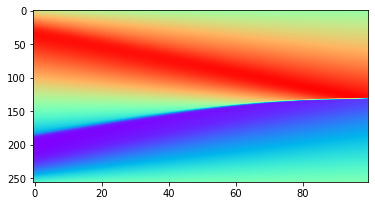

In [7]:
u_pred = PINN.test(X_u_test_tensor)

cmap = plt.cm.rainbow
plt.imshow(np.transpose(u_pred.reshape(100,256)),cmap = cmap,aspect = 0.2)

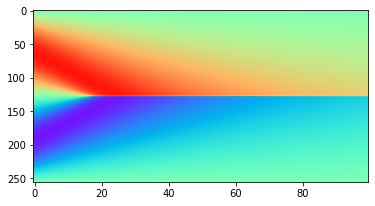

In [8]:
cmap = plt.cm.rainbow
plt.imshow(np.transpose(u_true.reshape(100,256)),cmap = cmap,aspect = 0.2)

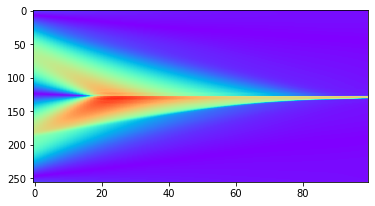

In [9]:
cmap = plt.cm.rainbow
plt.imshow(np.transpose(np.abs(u_pred - u_true).reshape(100,256)),cmap = cmap,aspect = 0.2)

In [10]:
a = 0 
for i in range(10):
    print(test_loss_full[i][-1])
    a = a + test_loss_full[i][-1]
print(a/10)

10.564832629318865


IndexError: list index out of range